## Determinantal Point Process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from scipy.interpolate import fitpack,bisplrep,bisplev
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded.")

Packages loaded.


### Util

In [2]:
def kernel_se(X1,X2,hyp={'g':1,'l':1}):
    """
        Squared exponential (SE) kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    return K

def grid_2d(x0_min,x0_max,x1_min,x1_max,x0_step,x1_step):
    x0s,x1s = np.meshgrid(np.arange(x0_min,x0_max+x0_step,x0_step),
                          np.arange(x1_min,x1_max+x1_step,x1_step))
    xs = np.dstack([x0s,x1s]).reshape(-1,2) 
    return xs,x0s,x1s

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    from mpl_toolkits import axes_grid1
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def gmm(x,weights,mus,sigmas):
    n = x.shape[0]
    prob = np.zeros(shape=(n,1))
    for i_idx,x_i in enumerate(x):
        p_i = 0
        for weight,mu,sigma in zip(weights,mus,sigmas):
            weight = weight / np.array(weights).sum()
            p_i = p_i + weight*multivariate_normal.pdf(x_i,mean=mu,cov=sigma)
        prob[i_idx,0] = p_i
    return prob

class QualityMapClass(object):
    def __init__(self,
                 name        = 'QM',
                 axis_info   = [-1.5,1.5,-1,1],
                 step_coarse = 0.05,
                 step_fine   = 0.01,
                 gmm_weights = [1,2,3],
                 gmm_mus     = [
                     np.array([-1.0,-0.5]),
                     np.array([0.0,0.0]),
                     np.array([1.0,0.5])
                     ],
                 gmm_sigmas  = [
                     0.1*np.array([[1.0,0.0],[0.0,1.0]]),
                     0.1*np.array([[1.0,0.0],[0.0,1.0]]),
                     0.1*np.array([[1.0,0.0],[0.0,1.0]])
                     ]
                ):
        self.name        = name
        self.axis_info   = axis_info
        self.step_coarse = step_coarse
        self.step_fine   = step_fine
        self.gmm_weights = gmm_weights
        self.gmm_mus     = gmm_mus
        self.gmm_sigmas  = gmm_sigmas
        
        # Define a GMM for the quality map
        xs,x0s,x1s = grid_2d(x0_min  = self.axis_info[0],
                             x0_max  = self.axis_info[1],
                             x1_min  = self.axis_info[2],
                             x1_max  = self.axis_info[3],
                             x0_step = self.step_coarse,
                             x1_step = self.step_coarse)
        self.xs_coarse  = xs
        self.x0s_coarse = x0s
        self.x1s_coarse = x1s
        self.prob = gmm(
            x       = self.xs_coarse,
            weights = self.gmm_weights,
            mus     = self.gmm_mus,
            sigmas  = self.gmm_sigmas)
        self.tck_coarse = bisplrep(
            x  = self.xs_coarse[:,0],
            y  = self.xs_coarse[:,1],
            z  = self.prob/max(self.prob),
            s  = 0.001,
            kx = 3,
            ky = 3)
        # 2D interpolating function and the qaulity map
        xs,x0s,x1s = grid_2d(x0_min  = self.axis_info[0],
                             x0_max  = self.axis_info[1],
                             x1_min  = self.axis_info[2],
                             x1_max  = self.axis_info[3],
                             x0_step = self.step_fine,
                             x1_step = self.step_fine)
        self.xs_fine  = xs
        self.x0s_fine = x0s
        self.x1s_fine = x1s
        self.Q    = bisplev(
            np.arange(self.axis_info[0],self.axis_info[1]+self.step_fine,self.step_fine),
            np.arange(self.axis_info[2],self.axis_info[3]+self.step_fine,self.step_fine),
            self.tck_coarse).T
    
    def get_meas(self,n_meas=100):
        """
            Make measurements
        """
        x_meas = np.array([self.axis_info[0],self.axis_info[2]]) \
            + np.array([self.axis_info[1]-self.axis_info[0],
                        self.axis_info[3]-self.axis_info[2]])*np.random.rand(n_meas,2)
        y_meas = np.zeros(shape=(n_meas))
        for i_idx in range(n_meas):
            y_meas[i_idx] = bisplev(x=x_meas[i_idx,0],y=x_meas[i_idx,1],tck=self.tck_coarse)
        return x_meas,y_meas
    
print ("Done.")

Done.


### Original k-DPP Implementation

In [3]:
def run_kdpp(
    xs_total = np.random.rand(1000,2),
    n_select = 10,
    hyp      = {'g':1.0,'l':0.1},
    qs_total = None
    ):
    """
        k-DPP
    """
    n_total     = xs_total.shape[0]
    idxs_remain = np.arange(0,n_total,1,dtype=np.int32)
    idxs_select = []
    for i_idx in range(n_select+1):
        if i_idx == 0:
            idx_select = np.random.permutation(n_total)[0] # first sample random
        else:
            xs_select = xs_total[idxs_select,:]
            n_remain  = len(idxs_remain)
            dets      = np.zeros(shape=n_remain)
            for r_idx in range(n_remain): # for the remained indices
                idx_check  = idxs_remain[r_idx]
                idxs_check = idxs_select + [idx_check]
                xs_check   = xs_total[idxs_check,:]
                # Compute the determinant of the kernel matrix
                K_check    = kernel_se(xs_check,xs_check,hyp={'g':1,'l':0.1})
                if qs_total is not None:
                    K_check = K_check + np.diag(qs_total[idxs_check])
                det_check  = np.linalg.det(K_check)
                # Append the determinant
                dets[r_idx] = det_check
            # Get the index with the highest determinant
            idx_select = idxs_remain[np.where(dets == np.amax(dets))[0][0]]
        # Remove currently selected index from 'idxs_remain'
        idxs_remain = idxs_remain[idxs_remain != idx_select]
        # Append currently selected index to 'idxs_select'
        idxs_select.append(idx_select)
    
    # Select the subset from 'xs_total' with removing the first sample
    idxs_select = idxs_select[1:]
    idxs_select = np.array(idxs_select)
    xs_kdpp     = xs_total[idxs_select]
    return xs_kdpp,idxs_select
print ("Done.")

Done.


xs_kdpp:(30, 2)


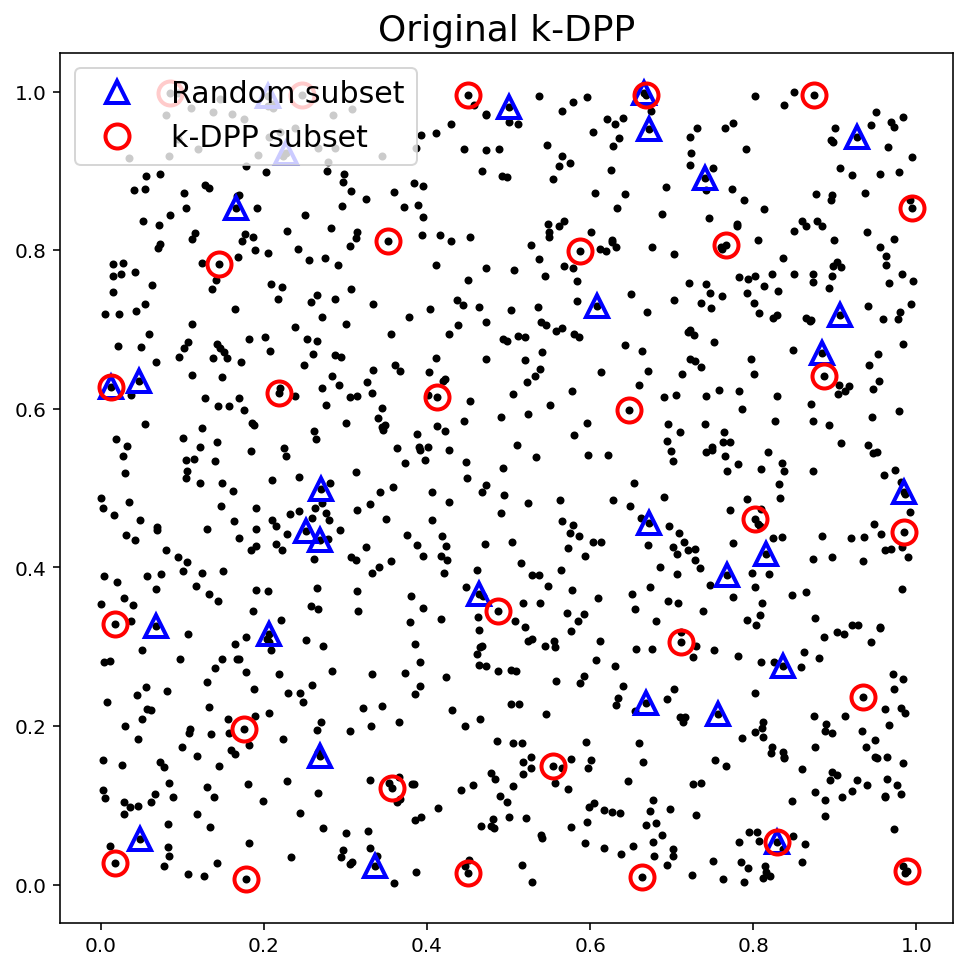

In [4]:
# Total set
n_total  = 1000
xs_total = np.random.rand(n_total,2)

# k-DPP
n_select    = 30
xs_kdpp,idxs_select = run_kdpp(
    xs_total = xs_total,
    n_select = n_select,
    hyp      = {'g':1.0,'l':0.5})
print ("xs_kdpp:%s"%(xs_kdpp.shape,))
xs_rand     = xs_total[np.random.permutation(n_total)[:n_select]]

# Plot
plt.figure(figsize=(8,8))
plt.plot(xs_total[:,0],xs_total[:,1],'.',color='k')
plt.plot(xs_rand[:,0],xs_rand[:,1],
         '^',ms=11,mfc='None',mec='b',markeredgewidth=2,
         label='Random subset')
plt.plot(xs_kdpp[:,0],xs_kdpp[:,1],
         'o',ms=12,mfc='None',mec='r',markeredgewidth=2,
         label='k-DPP subset')
plt.title("Original k-DPP",fontsize=18)
plt.legend(fontsize=15,loc='upper left')
plt.show()

### k-DPP with scores

In [5]:
# Define the Quality map
QM = QualityMapClass()
print ("[%s] Ready."%(QM.name))

[QM] Ready.


In [6]:
# Make measurements
n_meas = 1000
x_meas,y_meas = QM.get_meas(n_meas=n_meas)
print ("Make [%d] measurements."%(n_meas))

Make [1000] measurements.


### Quality-based k-DPP

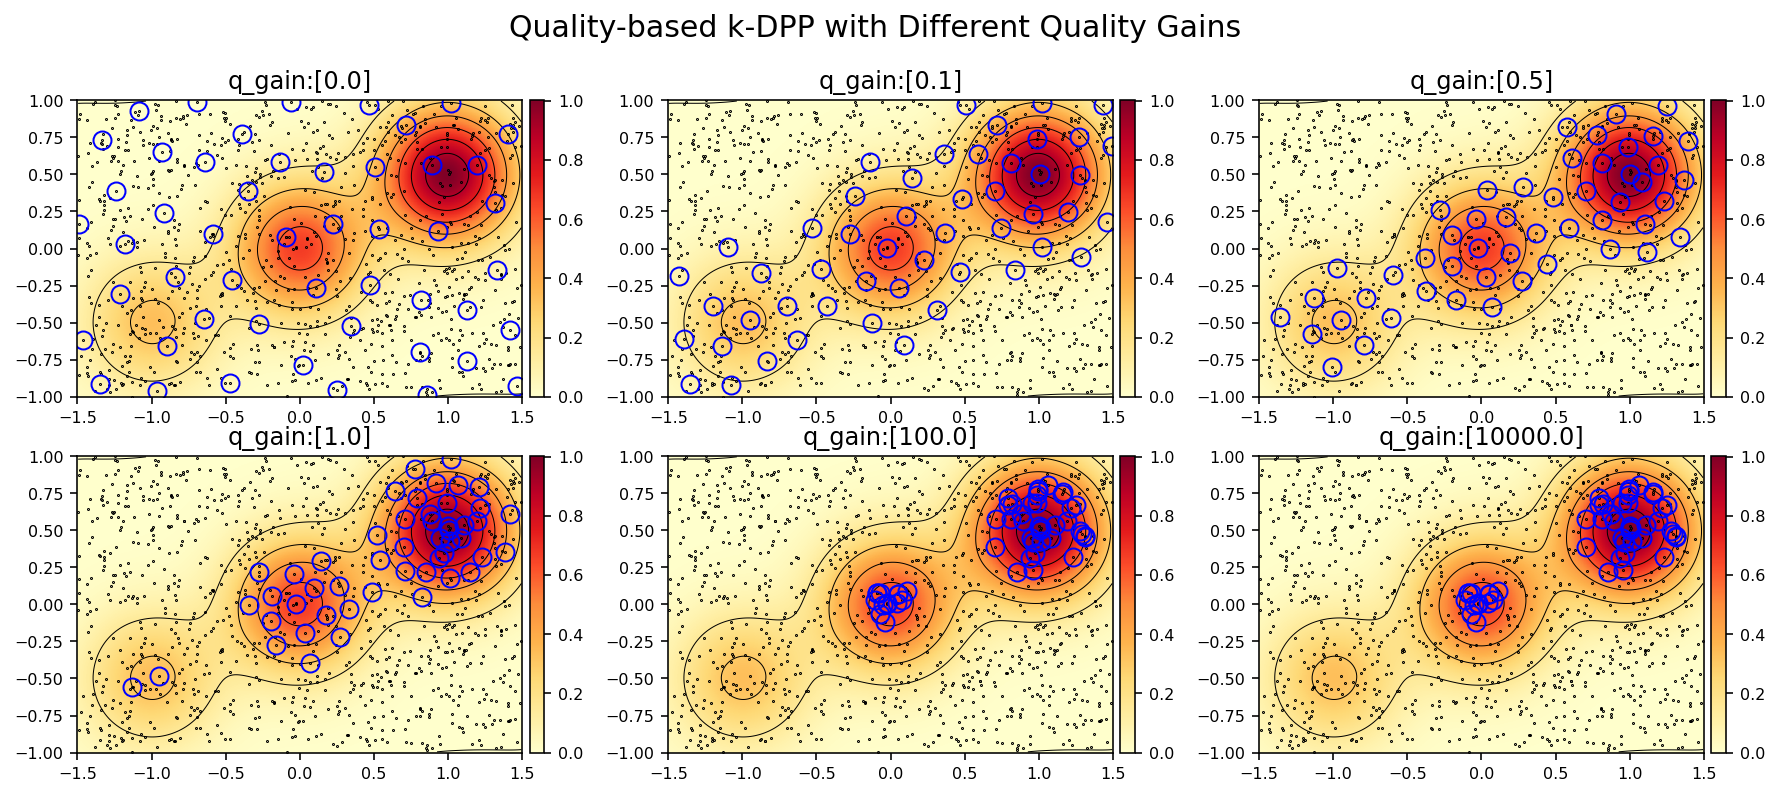

In [11]:
q_gains = [0.0,0.1,0.5,1.0,100.0,10000.0]
for q_idx,q_gain in enumerate(q_gains):
    # print ("[%d/%d] q_gain:[%.0f]"%(q_idx,len(q_gains),q_gain))
    # q-DPP
    n_select = 50
    xs_kdpp,idxs_select = run_kdpp(
        x_meas,
        n_select = n_select,
        hyp      = {'g':1.0,'l':0.1},
        qs_total = q_gain*y_meas
        )
    # Plot
    if q_idx == 0:
        plt.figure(figsize = (15,6))
        plt.rcParams.update({'font.size':8})
        plt.suptitle("Quality-based k-DPP with Different Quality Gains",fontsize=15)
    plt.subplot(2,3,q_idx+1)
    im = plt.imshow(X      = QM.Q,
                    extent = QM.axis_info,
                    cmap   = 'YlOrRd',
                    origin = 'lower')
    plt.contour(QM.Q,
                extent     = QM.axis_info,
                origin     = 'lower',
                colors     = 'k',
                linewidths = 1/2)
    plt.plot(x_meas[:,0],x_meas[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
    SHOW_QVAL = False
    if SHOW_QVAL:
        for i_idx in range(n_meas):
            y_offset = 0.04
            plt.text(x_meas[i_idx,0],x_meas[i_idx,1]+y_offset,'%.2f'%(y_meas[i_idx]),
                     fontsize=13,horizontalalignment='center',verticalalignment='center')
    plt.plot(xs_kdpp[:,0],xs_kdpp[:,1],
             'o',ms=9,mfc='None',mec='b',markeredgewidth=1,
             label='k-DPP subset') # plot kdpp samples
    plt.title('q_gain:[%.1f]'%(q_gain),fontsize=12)
    add_colorbar(im)
    plt.axis(QM.axis_info)
    plt.axis('equal')
plt.show()